## Proof of concept

This notebook must be moved to the root project directory to run; it walks through all the models.

## Linear Regression on BoW

In [7]:
from pathlib import Path  # https://realpython.com/python-pathlib/
import pandas as pd
from metrics.metrics import get_metrics

In [3]:
from models.bow_models import create_count_vector, train_bow_lr, format_df_to_bow

project_root = Path.cwd()
train_path = project_root.joinpath("dataset", "formatted_train.csv")
val_path = project_root.joinpath("dataset", "formatted_val.csv")
test_path = project_root.joinpath("dataset", "formatted_test.csv")

train_df = pd.read_csv(train_path).head(1000)
val_df = pd.read_csv(val_path).head(1000)
test_df = pd.read_csv(test_path).head(1000)

# Train model
cv = create_count_vector(train_df)
bow_lr_model = train_bow_lr(train_df, cv)

# Get accuracy
x_train, y_train = format_df_to_bow(cv, train_df)
x_val, y_val = format_df_to_bow(cv, val_df)
print("Train accuracy: ", round(bow_lr_model.score(x_train, y_train), 3))
print("Validation Accuracy: ", round(bow_lr_model.score(x_val, y_val), 3))

Train accuracy:  1.0
Validation Accuracy:  0.765


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    )

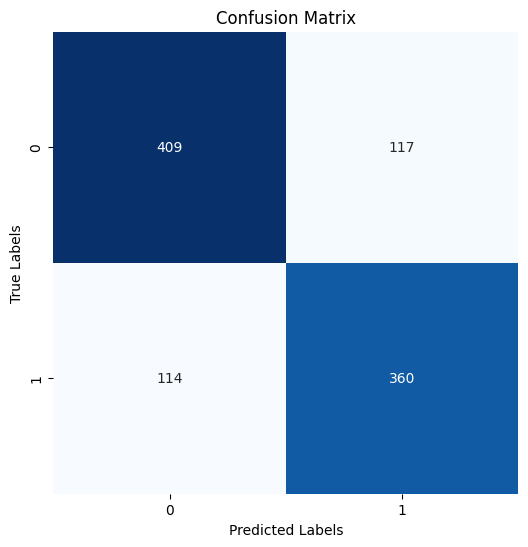

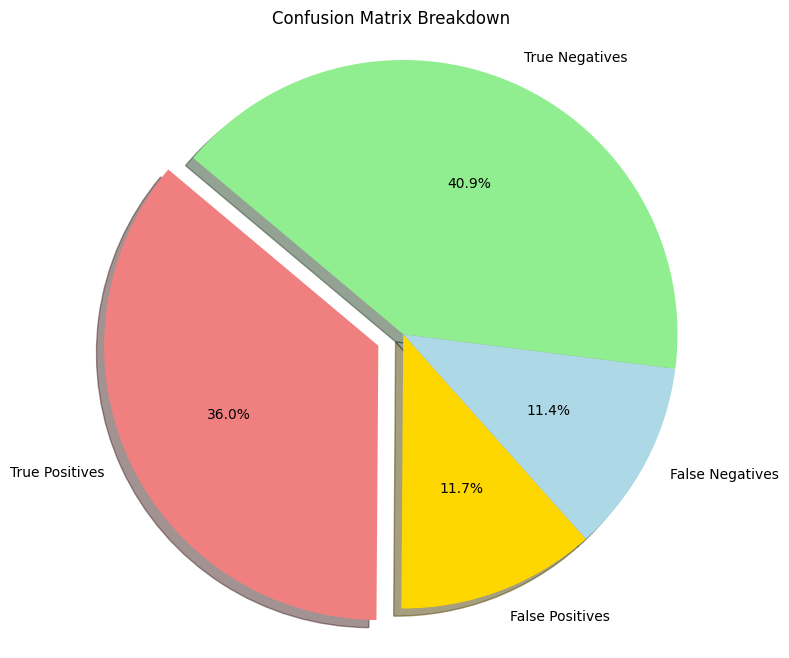

In [8]:
x_test, y_test = format_df_to_bow(cv, test_df)
lr_metrics_dir = project_root.joinpath("metrics", "bow_lr_test")
Path(lr_metrics_dir).mkdir(parents=True, exist_ok=True)
get_metrics(bow_lr_model, x_test, y_test, lr_metrics_dir)

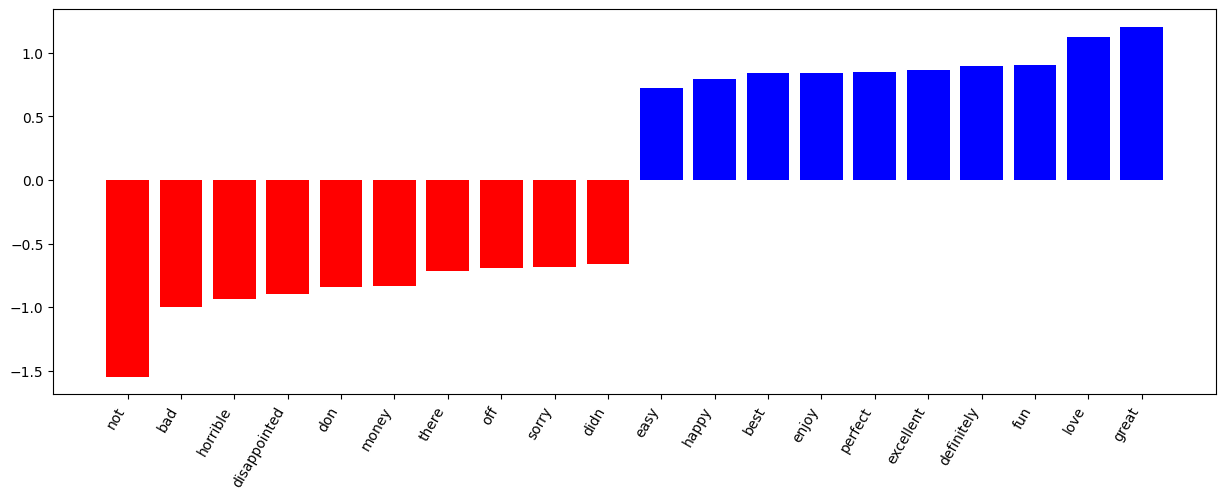

In [9]:
visualize_coefficients(bow_lr_model, cv.get_feature_names_out(), 10)

## Feedforward MLP on BoW

In [10]:
from models.bow_models import train_bow_mlp, get_metrics

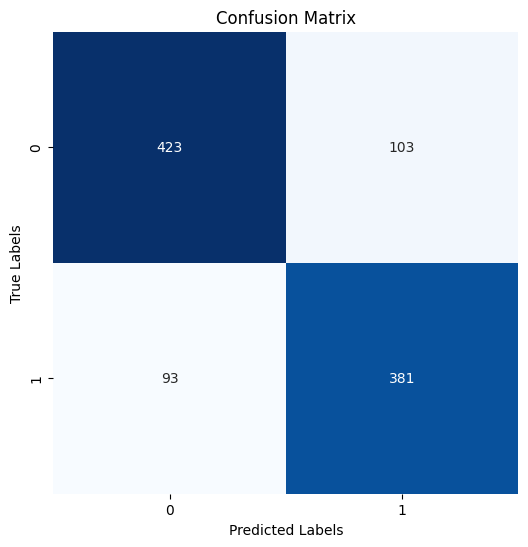

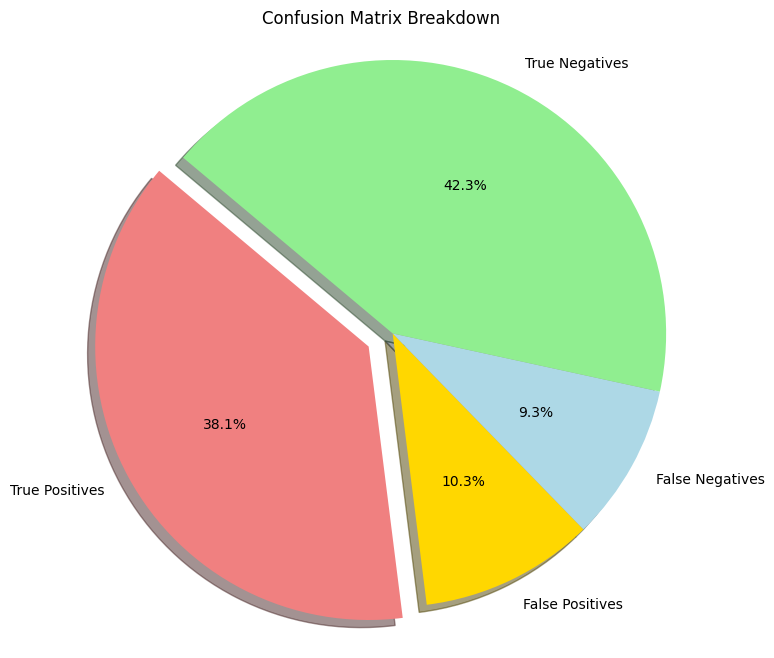

In [11]:
bow_mlp_model = train_bow_mlp(train_df, cv)
mlp_metrics_dir = project_root.joinpath("metrics", "bow_mlp_test")
Path(mlp_metrics_dir).mkdir(parents=True, exist_ok=True)
get_metrics(bow_mlp_model, x_test, y_test, mlp_metrics_dir)

## LSTM

In [12]:
import torch
from torch import nn
import model_runner
import embeddings
import dataset
import os
from models.lstm import review_LSTM

In [14]:
# Reader to get train and val data from csv
reader = dataset.csv_reader()

# Open formatted_train.csv
reader.open_csv(train_path, skip_header=True)
train_reviews = reader.read(1000)

# And formatted_val.csv
reader.open_csv(val_path, skip_header=True)
val_reviews = reader.read(1000)

In [15]:
# Intialize the embedder to use the glove-wiki-gigaword-50 embedding dictionary
# https://github.com/piskvorky/gensim-data#:~:text=org/licenses/pddl/-,glove%2Dwiki%2Dgigaword%2D50,-400000
review_embedder = embeddings.review_embedder(review_labels=["negative", "positive"], embedding_model="glove-wiki-gigaword-50", oov_feature=True, title_body_feature=True)

In [16]:
# If we tried to embed our entire training dataset into feature vectors at once, it would utilize over 100GB of RAM,
# which is unrealistic for most computers. The batched_review_embedder_sampler class embeds samples a few at a time,
# reducing RAM usage compared to a traditional DataLoader, at the expense of needing to re-embed the reviews every epoch
train_sampler = embeddings.batched_review_embedder_sampler(train_reviews, review_embedder, batch_size=50)
val_sampler = embeddings.batched_review_embedder_sampler(val_reviews, review_embedder, batch_size=50)

# Testing the samplers
x_sample, y_sample = next(iter(train_sampler))
x_sample.data.shape, x_sample.batch_sizes[0], y_sample.shape

(torch.Size([4115, 52]), tensor(50), torch.Size([50, 2]))

In [17]:
# Model hyperparameters
input_size = review_embedder.feature_embedding_size
hidden_size = 100
output_size = 2
num_layers = 1

# The output classifier makes a final prediction of the label based on the final hidden state of the LSTM; this could be
# any feedforward architecture, but as a starting point a single linear layer is used. The output should have a softmax
# activation in order for out cross entropy loss function to work well
output_classifier = nn.Sequential(nn.Linear(hidden_size * num_layers, output_size), nn.Softmax(dim=1))

# The full model consists of an LSTM RNN and the output classifier defined above
model = review_LSTM(input_size, hidden_size, output_classifier, num_layers)

In [18]:
# Model optimizer objects
optim = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
# Create a model runner to handle training
runner = model_runner.runner(model_name="LSTM_test", model=model, optimizer=optim, loss_fn=loss_fn)

In [20]:
# Train that model!
#from wakepy import keep

#with keep.running() as k:
#    print("Successfully locked PC to prevent it sleeping during training!" if k.success else "Wasn't able to lock PC from sleeping during training!")
runner.train(train_sampler, num_epochs=1, val_batch_iterable=val_sampler, autosave_interval_epochs=1)

Evaluating model predictions: 100%|██████████| 20/20 [00:01<00:00, 11.28batches/s]

Reached epoch save interval, saving model state...


In [21]:
# Open the test dataset
test_path = os.path.join(os.path.curdir, "dataset", "formatted_test.csv")
reader.open_csv(test_path, skip_header=True)
test_reviews = reader.read(1000)
test_sampler = embeddings.batched_review_embedder_sampler(test_reviews, review_embedder, batch_size=50)

In [22]:
# Evaluate the model's performance on the test dataset
y_test, yhat_test = runner.predict_dataset(test_sampler)

Evaluating model predictions: 100%|██████████| 20/20 [00:02<00:00,  9.65batches/s]


In [23]:
# We can now look at testing metrics using our predictions; here, we only consider accuracy
from sklearn.metrics import accuracy_score

print(y_test.shape, yhat_test.shape, accuracy_score(y_test, yhat_test), sep='\n')

torch.Size([1000])
torch.Size([1000])
0.539
